In [35]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingClassifier
import scipy
import json
from sklearn import metrics

In [2]:
ev = pd.read_csv('../dataset/evergreen.tsv', delimiter='\t')

In [3]:
ev.shape

(7395, 27)

In [4]:
# Get dummies for alchemy_category_score prior to train test split so dummies will be consistent

ev.alchemy_category = ev.alchemy_category.replace('unknown', '?')
dummies = pd.get_dummies(ev.alchemy_category)
dummies = dummies.drop('?', axis=1)
ev = ev.drop('alchemy_category', axis=1)
ev = pd.concat([ev, dummies], axis=1)

In [5]:
ev.shape

(7395, 38)

In [6]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(ev.drop('label', axis=1), ev.label, random_state=14)
# Clean and scale X_train and X_test SAVING ORIGINALS INTACT FOR TEXT CLASSIFIERS

In [7]:
def cleanup(ev):
    # convert alchemy_category_score to float64, replacing '?' with 0
    ev.alchemy_category_score = ev.alchemy_category_score.replace('?', '0')
    ev.alchemy_category_score = ev.alchemy_category_score.apply(lambda x: float(x))
    # replace'?' in all of ev with 0
    ev = ev.replace('?', 0)
    # do not include commonlinkratio_1.  its coefficient on logistic regression is 0
    # do not include framebased.  It's all 0
    # url, urlid, and boilerplate are text
    ev = ev.drop(['url', 'urlid', 'boilerplate', 'commonlinkratio_1', 'framebased'], axis=1)
    # All features are now numerical
    ev = StandardScaler().fit_transform(ev)
    return ev

In [8]:
X_train_clean = cleanup(X_train)
X_test_clean = cleanup(X_test)

## Build logistic regression model

In [9]:
param_grid = dict(penalty=['l1','l2'], C =[.1, .5,1,2,5,10])

# Optimize for roc_auc since that is what kaggle asked for
cv = GridSearchCV(LogisticRegression(), param_grid, scoring = 'roc_auc', cv=20)

cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l2', 'C': 0.5}
0.73092406769


## Build random forest classifier

In [10]:
param_grid = dict(n_estimators=[20,50,100], min_samples_leaf=[1,5, 8, 10, 20], min_samples_split=[2,5,10,20])

# Make cv smaller since rfc is slower
cv = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc', cv=10)

cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'min_samples_split': 20, 'n_estimators': 100, 'min_samples_leaf': 5}
0.776361363258


## Build ExtraTreesClassifier

In [11]:
param_grid = dict(n_estimators=[10, 20,50, 100], min_samples_leaf=(1, 3, 5, 8, 10))

cv = GridSearchCV(ExtraTreesClassifier(), param_grid, scoring='roc_auc', cv=5)
cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
{'n_estimators': 100, 'min_samples_leaf': 3}
0.761771733749


## Build Decision Tree Classifier with AdaBoost

In [12]:
# First refine decision tree classifier

dt = DecisionTreeClassifier()

param_grid = dict(criterion=['gini', 'entropy'] , min_samples_leaf=(1, 3, 5, 8, 10), max_depth=[3,5,10,None])

cv = GridSearchCV(dt, param_grid, scoring='roc_auc', cv=20)
cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}
0.695406671224


In [13]:
dt = cv.best_estimator_    #defined above for decision tree classifier

bdt = AdaBoostClassifier(dt)

param_grid = dict(n_estimators=[10,20,50,100] , learning_rate=[1,1.5,3])

cv = GridSearchCV(bdt, param_grid, scoring='roc_auc', cv=5)
cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1, n_estimators=100, random_state=None)
{'n_estimators': 100, 'learning_rate': 1}
0.724140151344


## Build SVM

In [17]:
param_grid = dict(C=[1,1.5,3], kernel=['linear', 'rbf'])

# Keep cv at 3
cv = GridSearchCV(SVC(max_iter=5000), param_grid, scoring='roc_auc')
cv.fit(X_train_clean, y_train)

print cv.best_estimator_ 
print cv.best_score_

//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=5000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.749739231383


## Build K-NN Classifier

In [12]:
param_grid = dict(n_neighbors = [1,5,10, 50])

cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
{'n_neighbors': 10}
0.657410746484


RFC is the best so far.

## Perform PCA and redo greatest hits from above

In [13]:
corr = pd.DataFrame(X_train_clean).corr()

# find high correlations only
def find_big(x):
    if x <=.7:
        return 0
    else: return x

for feature in corr.columns:
    corr[feature] = corr[feature].apply(find_big)

In [14]:
# commonlinkratios  2, 3, 4 are correlated (1 is excluded already)
# drop ratio 3.  correlations between ratios 2 and 4 is just .55, which is ok

print X_train_clean.shape
X_train_clean = scipy.delete(X_train_clean, 3, 1)
print X_train_clean.shape

(5546, 32)
(5546, 31)


In [15]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_clean)
print(pca.explained_variance_ratio_) 

[ 0.09380469  0.07360634  0.05635803  0.04789645  0.04401961  0.04087237
  0.0376342   0.03671227  0.03623273  0.034714    0.03415601  0.03368696
  0.03343293  0.0327352   0.03247744  0.03218671  0.03207985  0.030875
  0.03028984  0.02854762  0.02648424  0.02423231  0.02246269  0.0217596
  0.02077486  0.01798296  0.01604891  0.0126124   0.00949318  0.00361462
  0.00221596]


In [16]:
cumulvarExpl = np.cumsum(pca.explained_variance_ratio_)

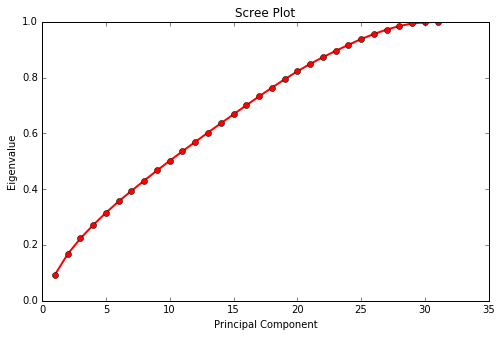

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(31) + 1
plt.plot(sing_vals, cumulvarExpl, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

In [18]:
# Uh, this line doesn't really 'bend'
# bad sign?
# Let's do the first 29 components

pca = PCA(n_components=29)
X_train_pca = pca.fit_transform(X_train_clean)

## Redo models on X_train_pca

In [19]:
# Random forest

param_grid = dict(min_samples_split=[2,5,10,20,50])
rfc = RandomForestClassifier(n_estimators=100)

cv = GridSearchCV(rfc, param_grid, scoring='roc_auc')

cv.fit(X_train_pca, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'min_samples_split': 20}
0.745034926363


In [20]:
# ExtraTrees

param_grid = dict(min_samples_leaf=(1, 3, 5, 8, 10))

cv = GridSearchCV(ExtraTreesClassifier(n_estimators=100), param_grid, scoring='roc_auc', cv=5)
cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
{'min_samples_leaf': 1}
0.761546537697


In [21]:
param_grid = dict(C=[1,1.5,3], kernel=['linear', 'rbf'])

# This one is slow.
# Keep cv at 3
cv = GridSearchCV(SVC(), param_grid, scoring='roc_auc')
cv.fit(X_train_clean, y_train)

print cv.best_estimator_ 
print cv.best_params_
print cv.best_score_

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'kernel': 'rbf', 'C': 3}
0.746156060494


Pca makes models slightly worse.

## Explore Feature Selection

### Start with SelectKbest and RFC

In [46]:
## Try other feature selection here
## How many features should I select?

SKB = SelectKBest(f_classif, k=31).fit(X_train_clean, y_train)

In [52]:
f_scores = SKB.scores_

In [63]:
f_scores = np.sort(f_scores)
f_scores = f_scores[::-1]

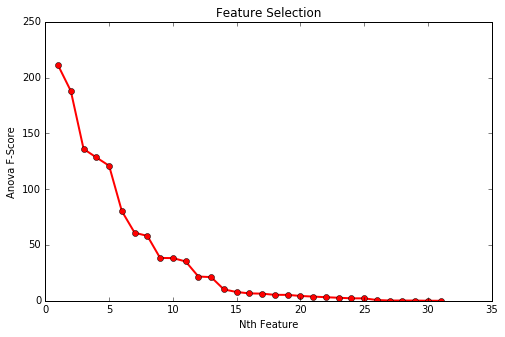

In [65]:
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(31) + 1
plt.plot(sing_vals, f_scores, 'ro-', linewidth=2)
plt.title('Feature Selection')
plt.xlabel('Nth Feature')
plt.ylabel('Anova F-Score')

In [66]:
# Select 14 best features.

SKB = SelectKBest(f_classif, k=14).fit(X_train_clean, y_train)
X_new = SKB.transform(X_train_clean)

In [68]:
X_new.shape

(5546, 14)

### RFC on best 14 features

In [69]:
# Random forest

param_grid = dict(min_samples_split=[2,5,10,20,50])
rfc = RandomForestClassifier(n_estimators=100)

cv = GridSearchCV(rfc, param_grid, scoring='roc_auc')

cv.fit(X_new, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'min_samples_split': 20}
0.752203576384


RFC is slightly worse
But feature selection is more important on parametric models

### Logistic Regression on 14 best features

In [70]:
param_grid = dict(penalty=['l1','l2'], C =[.1, .5,1,2,5,10])

# Optimize for roc_auc since that is what kaggle asked for
cv = GridSearchCV(LogisticRegression(), param_grid, scoring = 'roc_auc', cv=20)

cv.fit(X_train_clean, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l1', 'C': 0.1}
0.729325611101


In [74]:
### SVM on 14 best features

param_grid = dict(C=[1,1.5,3], kernel=['linear', 'rbf'])

# This one is slow.
# Keep cv at 3
cv = GridSearchCV(SVC(max_iter=3000), param_grid, scoring='roc_auc')
cv.fit(X_train_clean, y_train)

print cv.best_estimator_ 
print cv.best_params_
print cv.best_score_

//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=3000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'kernel': 'rbf', 'C': 3}
0.746091971202


Once again, this model is slightly worse than one built on all features.

### Before we give up on feature selection, let's use a random forest to select the best features

In [75]:
# This was our best model from the grid searches above
rfc = RandomForestClassifier(min_samples_split=5, n_estimators=100).fit(X_train_clean, y_train)

In [80]:
f_imps = np.sort(rfc.feature_importances_)[::-1]

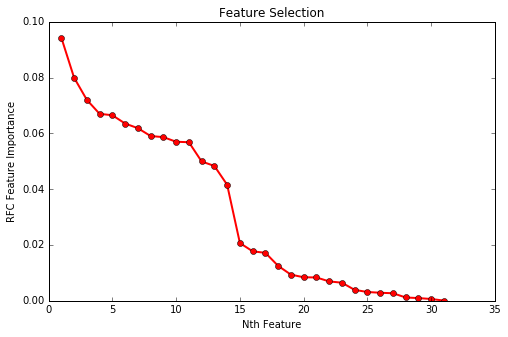

In [81]:
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(31) + 1
plt.plot(sing_vals, f_imps, 'ro-', linewidth=2)
plt.title('Feature Selection')
plt.xlabel('Nth Feature')
plt.ylabel('RFC Feature Importance')

Once again, we see a sharp drop in feature importance after the top 14.  However, let's try a few more features to see if we can improve our models over the ones built on the SelectKBest top 14 above (I have a hunch these may be the same 14 features).

Save top 19 features from RFC

In [104]:
f_imps[18]

# Cutoff value is 8.43592326e-03

0.0093795455264312055

In [105]:
# Identify top 19 features in X_train_clean

# Create mask for X_train clean from feature importances

mask = np.where(rfc.feature_importances_>=.009375)

In [109]:
X_new2 = X_train_clean.T[mask].T
X_new2.shape

(5546, 19)

### Logistic Regression with top 19 features

In [111]:
param_grid = dict(penalty=['l1','l2'], C =[.1, .5,1,2,5,10])

cv = GridSearchCV(LogisticRegression(), param_grid, scoring = 'roc_auc', cv=20)

cv.fit(X_new2, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l1', 'C': 0.5}
0.726782831893


This is actually doing WORSE than the top 14 features.  Oh well.

### SVM with top 19 features

In [112]:
param_grid = dict(C=[1,1.5,3], kernel=['linear', 'rbf'])

# Keep cv at 3
cv = GridSearchCV(SVC(max_iter=3000), param_grid, scoring='roc_auc')
cv.fit(X_train_clean, y_train)

print cv.best_estimator_ 
print cv.best_params_
print cv.best_score_

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=3000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'kernel': 'rbf', 'C': 3}
0.746091971202


*Shrugs*

RFC on all features still produces best model.  C'est la vie.

In [18]:
best_num_model = RandomForestClassifier(min_samples_split=5, n_estimators=100).fit(X_train_clean, y_train)

## Predict label from article text and title

In [19]:
def make_dict(X):
    return json.loads(X)
X_train.boilerplate = X_train.boilerplate.apply(make_dict)
X_test.boilerplate = X_test.boilerplate.apply(make_dict)

In [41]:
# Save titles and bodies of text from X_train and X_test boilerplate

def get_title(x):
    try:
        return x['title']
    except: return ''
    
X_train_title = X_train.boilerplate.apply(get_title)
X_test_title = X_test.boilerplate.apply(get_title)

X_train_title = X_train_title.replace(np.nan, '')
X_test_title = X_test_title.replace(np.nan, '')

X_train_body = X_train.boilerplate.apply(lambda x: x['body'])
X_test_body = X_test.boilerplate.apply(lambda x: x['body'])

X_train_body = X_train_body.replace(np.nan, '')
X_test_body = X_test_body.replace(np.nan, '')

### Compare tfidf and count vectorization

In [114]:
pipe = make_pipeline(CountVectorizer(stop_words='english'), MultinomialNB())
cross_val_score(pipe, X_train_body, y_train, cv=10, scoring='roc_auc').mean()

0.83365892253357199

In [115]:
pipe = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())
cross_val_score(pipe, X_train_body, y_train, cv=10, scoring='roc_auc').mean()

0.86621317767230488

### Grid search optimal ngram range, max_df, and min_df for tfidf vectorizer with Multinomial NB

In [27]:
# Grid search n-gram range

param_grid = dict(vec__ngram_range=[(1, i) for i in range(1,5)], vec__max_df=[1,20,50,100])
vec = CountVectorizer(stop_words='english')

NB = MultinomialNB()

pipe = Pipeline(steps=[('vec', vec), ('NB', NB)])


cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X_train_body, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

Pipeline(steps=[('vec', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('NB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
{'vec__max_df': 100, 'vec__ngram_range': (1, 1)}
0.839631531213


### Classify text with SVM

In [116]:
param_grid = dict(svc__C=[1,1.5,2,3], svc__kernel=['rbf', 'linear'], vec__max_df=[1,20,50,100])
vec = TfidfVectorizer(stop_words='english')

svc = SVC(max_iter=2000)

pipe = Pipeline(steps=[('vec', vec), ('svc', svc)])


cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=10)

cv.fit(X_train_body, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,...  max_iter=2000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
{'vec__max_df': 100, 'svc__kernel': 'rbf', 'svc__C': 3}
0.858702285862


### Classify text with random forest

In [29]:
param_grid = dict(vec__max_df=[1,20,50,100], rfc__min_samples_split=[2,5,10,20])
vec = CountVectorizer(stop_words='english')

rfc = RandomForestClassifier(n_estimators=50)

pipe = Pipeline(steps=[('vec', vec), ('rfc', rfc)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X_train_body, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

Pipeline(steps=[('vec', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
      ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
{'rfc__min_samples_split': 5, 'vec__max_df': 100}
0.85436527997


### Classify text with logistic regression

In [117]:
param_grid = dict(vec__max_df=[1,20,50,100],lr__C=[.1,.5,1,3,5])
vec = TfidfVectorizer(stop_words='english')

lr = LogisticRegression()

pipe = Pipeline(steps=[('vec', vec), ('lr', lr)])


cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=10)

cv.fit(X_train_body, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
{'vec__max_df': 100, 'lr__C': 0.5}
0.86265860498


In [42]:
best_text_model = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())

## Classify Titles

In [118]:
pipe = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(1,1)), MultinomialNB())
cross_val_score(pipe, X_train_title, y_train, cv=10, scoring='roc_auc').mean()

0.83963451572825998

In [119]:
pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(1,1)), MultinomialNB())
cross_val_score(pipe, X_train_title, y_train, cv=10, scoring='roc_auc').mean()

0.84540643438980045

In [122]:
# Grid search n-gram range and max_df

param_grid = dict(vec__ngram_range=[(1, i) for i in range(1,5)], vec__max_df=[1,20,50,100])
vec = TfidfVectorizer(stop_words='english')

NB = MultinomialNB()

pipe = Pipeline(steps=[('vec', vec), ('NB', NB)])


cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=10)

cv.fit(X_train_title, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,...True,
        vocabulary=None)), ('NB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
{'vec__max_df': 100, 'vec__ngram_range': (1, 3)}
0.835388562557


### Classify titles with SVM

In [34]:
param_grid = dict(svc__C=[1,1.5,2,3], svc__kernel=['rbf', 'linear'], vec__max_df=[1,20,50,100])
vec = TfidfVectorizer(stop_words='english')

svc = SVC(max_iter=10)

pipe = Pipeline(steps=[('vec', vec), ('svc', svc)])


cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=10)

cv.fit(X_train_title, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
{'vec__max_df': 100, 'svc__kernel': 'rbf', 'svc__C': 3}
0.825221279008


### Classify titles with random forest

In [35]:
param_grid = dict(vec__max_df=[1,20,50,100], rfc__min_samples_split=[2,5,10,20])
vec = CountVectorizer(stop_words='english')

rfc = RandomForestClassifier(n_estimators=50)

pipe = Pipeline(steps=[('vec', vec), ('rfc', rfc)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=10)

cv.fit(X_train_title, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

Pipeline(steps=[('vec', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
      ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
{'rfc__min_samples_split': 5, 'vec__max_df': 100}
0.806155202432


### Classify titles with logistic regression

In [124]:
param_grid = dict(vec__max_df=[1,20,50,100],lr__C=[.1,.5,1,3,5])
vec = TfidfVectorizer(stop_words='english')

lr = LogisticRegression()

pipe = Pipeline(steps=[('vec', vec), ('lr', lr)])


cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=10)

cv.fit(X_train_body, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=100, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
{'vec__max_df': 100, 'lr__C': 0.5}
0.86265860498


In [22]:
best_title_model = make_pipeline(TfidfVectorizer(stop_words='english', max_df=100), LogisticRegression(C=.5))

## Combine best analysis of numerical data with text analysis

In [23]:
# Build custom transformers to preprocess data so all three analyses can be pipelined from X_train

class NumClean(BaseEstimator, TransformerMixin):
    """Clean up numerical features, create dummies, and drop text"""

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return cleanup(X)
    
class BodyClean(BaseEstimator, TransformerMixin):
    """Clean up numerical features, create dummies, and drop text"""

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        body = X.boilerplate.apply(lambda x: x['body'])
        body = body.replace(np.nan, '')
        return body
    
class TitleClean(BaseEstimator, TransformerMixin):
    """Clean up numerical features, create dummies, and drop text"""

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        title = X.boilerplate.apply(get_title)
        title = title.replace(np.nan, '')
        return title



In [24]:
# Rewrite each best model as a pipeline with required preprocessing

modelA =  Pipeline(steps=[('clean', NumClean()), ('model', best_num_model)])
modelB =  Pipeline(steps=[('clean', BodyClean()), ('model', best_text_model)])
modelC =  Pipeline(steps=[('clean', TitleClean()), ('model', best_title_model)])

In [25]:
eclf = VotingClassifier(estimators=[('numerical', modelA), ('body', modelB),
                                    ('title', modelC)],
                        voting='soft', weights=[1, 2, 1])

In [28]:
cv = cross_val_score(eclf, X_train, y_train, cv=5, scoring='roc_auc')

In [29]:
cv.mean()

0.87176064219617599

Nice!  The voting classifier outperforms my strongest model!  Can I refine it further by optimizing weights?

In [30]:
param_grid = dict(weights=[[1,1,1],[1,2,1],[1,3,1],[1,10,1],[2,3,2]])

eclf = VotingClassifier(estimators=[('numerical', modelA), ('body', modelB),
                                    ('title', modelC)], voting='soft')

cv = GridSearchCV(eclf, param_grid, scoring = 'roc_auc', cv=20)

cv.fit(X_train, y_train)

print cv.best_estimator_
print cv.best_params_
print cv.best_score_

VotingClassifier(estimators=[('numerical', Pipeline(steps=[('clean', NumClean()), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fra...', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]))]))],
         voting='soft', weights=[1, 2, 1])
{'weights': [1, 2, 1]}
0.871717904102


In [31]:
# Save best model

winner = cv.best_estimator_

In [49]:
y_pred_proba = winner.predict_proba(X_test)

In [52]:
y_pred_proba

array([[ 0.74053543,  0.25946457],
       [ 0.16651329,  0.83348671],
       [ 0.74739685,  0.25260315],
       ..., 
       [ 0.20330532,  0.79669468],
       [ 0.77147221,  0.22852779],
       [ 0.5431542 ,  0.4568458 ]])

In [55]:
X_test.shape

(1849, 37)

In [56]:
y_test.shape

(1849,)

In [61]:
metrics.roc_auc_score(y_test, y_pred_proba[:,1])

0.85549924050751414

This score is a little disappointing, given CV scores on training set.  

Just for fun, let's test our best text classification model and see how that did.

In [64]:
modelB.fit(X_train, y_train)

Pipeline(steps=[('clean', BodyClean()), ('model', Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smoo...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]))])

In [65]:
y_pred_proba = modelB.predict_proba(X_test)

In [66]:
metrics.roc_auc_score(y_test, y_pred_proba[:,1])

0.84535492523270428

Maybe this is just an unfavorable split.  Voting classifier did outperform best text classification model, both just did a little worse than we might have expected from CV.  Oh well.